In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt

dolar_or_euro = "Dolar" if 1 else "Euro"
DATASET_DIR= "dataset" + os.sep

In [37]:
df = pd.read_excel(DATASET_DIR + dolar_or_euro+'.xlsx') #verisetini okuyoruz

df['Tarih'] = pd.to_datetime(df['Tarih'], dayfirst=True) # Tarih sütununu datetime tipine çeviriyoruz, verisetimizde gün başta olduğu için dayfirst=True dedik
df = df.set_index('Tarih') # Tarih sütununu index olarak belirliyoruz

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2019-04-20 to 2024-04-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dolar   1253 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [39]:
df[dolar_or_euro].interpolate(method='linear', inplace=True) # Eksik verileri lineer olarak dolduruyoruz
df[dolar_or_euro] = df[dolar_or_euro].astype("float32") # Dolar sütununu float32 tipine çeviriyoruz

C:\Users\Emre\AppData\Local\Temp\ipykernel_5112\2344156794.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[dolar_or_euro].interpolate(method='linear', inplace=True) # Eksik verileri lineer olarak dolduruyoruz


In [40]:
df.dropna(inplace=True) # Eksik verileri siliyoruz

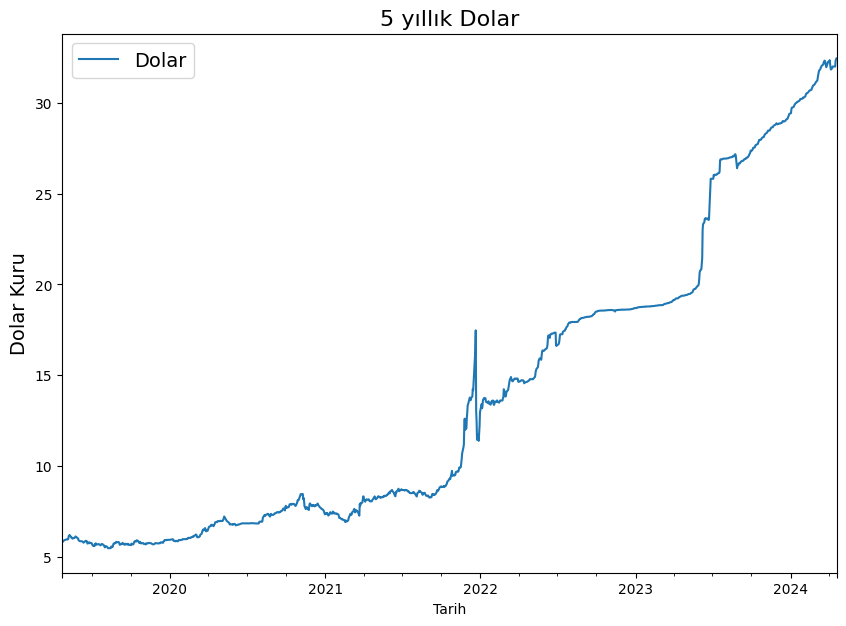

In [41]:
df.plot(figsize=(10,7)) # Verisetini çizdiriyoruz
plt.ylabel(dolar_or_euro+" Kuru", fontsize=14)
plt.title("5 yıllık "+dolar_or_euro, fontsize=16)
plt.legend(fontsize=14)

In [42]:
timesteps = df.index.to_numpy() # Tarih sütununu numpy arrayine çeviriyoruz
prices    = df[dolar_or_euro].to_numpy() # Dolar sütununu numpy arrayine çeviriyoruz

timesteps[:10], prices[:10]

(array(['2019-04-22T00:00:00.000000000', '2019-04-23T00:00:00.000000000',
        '2019-04-24T00:00:00.000000000', '2019-04-25T00:00:00.000000000',
        '2019-04-26T00:00:00.000000000', '2019-04-27T00:00:00.000000000',
        '2019-04-28T00:00:00.000000000', '2019-04-29T00:00:00.000000000',
        '2019-04-30T00:00:00.000000000', '2019-05-01T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([5.7921 , 5.8087 , 5.8253 , 5.8598 , 5.8927 , 5.9029 , 5.9131 ,
        5.9233 , 5.9282 , 5.94225], dtype=float32))

In [43]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test 
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1460, 365, 1460, 365)

In [44]:
def plot_time_series(timesteps, values, format=".",start=0,end=None, label=None): # Zaman serisini çizdirmek için fonksiyon
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Tarih")
    plt.ylabel(dolar_or_euro+" Kuru")

    if label:        
        plt.legend(fontsize=14)
        
    plt.grid(True)

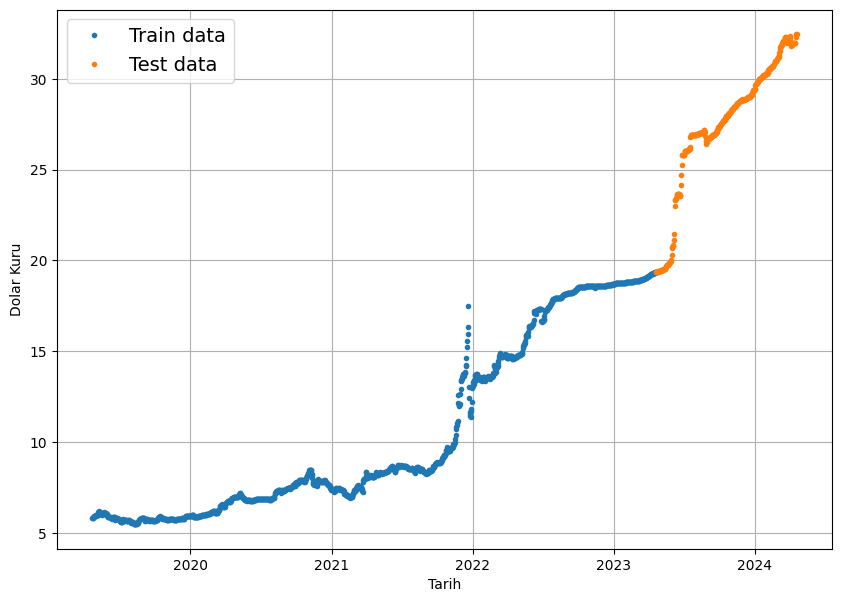

In [45]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [46]:
import tensorflow as tf

# MASE implementation 

def mean_absolute_scaled_error(y_true, y_pred): # MASE hesaplama fonksiyonu    
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season


In [47]:
def evaluate_preds(y_true, y_pred): # Modelin başarısını değerlendirmek için fonksiyon
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae  = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse  = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae" : mae.numpy(),
        "mse" : mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
        }


In [48]:
HORIZON = 1     # 1 gün sonrası için tahmin yapacağız
WINDOW_SIZE = 7 # 7 gün veri ile tahmin yapacağız

In [49]:
def get_labelled_windows(x, horizon=HORIZON):
    """  
    Verisetini pencereleme işlemi yapar ve etiketler.   
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """

    return x[:, :-horizon], x[:, -horizon:]

In [50]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [51]:
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """  
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.

    """

    # 1. Belirli boyutta pencere oluşturup pencere adımlarını belirliyoruz

    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Çoklu pencere adımlarını içeren 2D pencere dizisini oluşturuyoruz

    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T # 2 Boyutlu 
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Pencere dizisini kullanarak pencereleme işlemi yaparız

    windowed_array = x[window_indexes]
    # print(windowed_array)

    # 4. Etiketlenmiş pencere dizisini döndürüyoruz

    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels 


In [52]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(1818, 1818)

In [53]:
# İlk 3 pencere ve etiketleri

for i in range(3):
    print(f"Window: {full_windows[i]} -> Label {full_labels[i]}")

Window: [5.7921 5.8087 5.8253 5.8598 5.8927 5.9029 5.9131] -> Label [5.9233]
Window: [5.8087 5.8253 5.8598 5.8927 5.9029 5.9131 5.9233] -> Label [5.9282]
Window: [5.8253 5.8598 5.8927 5.9029 5.9131 5.9233 5.9282] -> Label [5.94225]


In [54]:
# Son 3 pencere ve etiketleri

for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label {full_labels[i-3]}")

Window: [32.006  32.006  32.006  32.006  32.006  32.006  32.3271] -> Label [32.4049]
Window: [32.006  32.006  32.006  32.006  32.006  32.3271 32.4049] -> Label [32.4626]
Window: [32.006  32.006  32.006  32.006  32.3271 32.4049 32.4626] -> Label [32.4551]


In [55]:
# Train ve test veri setlerini oluşturuyoruz

def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train / 20% test dataset
    train_windows = windows[:split_size]
    train_labels  = labels[:split_size]
    test_windows  = windows[split_size:]
    test_labels   = labels[split_size:] 

    return train_windows, test_windows, train_labels, test_labels

In [56]:
# Train ve test veri setlerini oluşturuyoruz

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1454, 364, 1454, 364)

In [57]:
train_windows[:5], train_labels[:5]

(array([[5.7921 , 5.8087 , 5.8253 , 5.8598 , 5.8927 , 5.9029 , 5.9131 ],
        [5.8087 , 5.8253 , 5.8598 , 5.8927 , 5.9029 , 5.9131 , 5.9233 ],
        [5.8253 , 5.8598 , 5.8927 , 5.9029 , 5.9131 , 5.9233 , 5.9282 ],
        [5.8598 , 5.8927 , 5.9029 , 5.9131 , 5.9233 , 5.9282 , 5.94225],
        [5.8927 , 5.9029 , 5.9131 , 5.9233 , 5.9282 , 5.94225, 5.9563 ]],
       dtype=float32),
 array([[5.9233 ],
        [5.9282 ],
        [5.94225],
        [5.9563 ],
        [5.9571 ]], dtype=float32))

In [58]:
test_windows[:5], test_labels[:5]

(array([[19.316767, 19.326534, 19.3363  , 19.3542  , 19.3755  , 19.3806  ,
         19.3806  ],
        [19.326534, 19.3363  , 19.3542  , 19.3755  , 19.3806  , 19.3806  ,
         19.3806  ],
        [19.3363  , 19.3542  , 19.3755  , 19.3806  , 19.3806  , 19.3806  ,
         19.3806  ],
        [19.3542  , 19.3755  , 19.3806  , 19.3806  , 19.3806  , 19.3806  ,
         19.3806  ],
        [19.3755  , 19.3806  , 19.3806  , 19.3806  , 19.3806  , 19.3806  ,
         19.3853  ]], dtype=float32),
 array([[19.3806],
        [19.3806],
        [19.3806],
        [19.3853],
        [19.3937]], dtype=float32))

In [59]:
import os 

# Modelin kaydedileceği klasörü belirliyoruz

def create_model_checkpoint(model_name, save_path="model_experiments"+os.sep+dolar_or_euro):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                                                    verbose=0,
                                                                    save_best_only=True)

In [60]:
def make_preds(model, input_data):
    # Tahmin yapmak için modeli kullanıyoruz
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # Tahminleri düzleştiriyoruz (tek boyuta indiriyoruz)

In [61]:
WINDOW_SIZE = 30 # 30 günlük veriyi kullanarak 1 gün sonrası tahmin yapacağız

In [62]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

len(full_windows), len(full_labels)

(1795, 1795)

In [63]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1436, 359, 1436, 359)

In [64]:
train_windows[:3], train_labels[:3]

(array([[5.7921   , 5.8087   , 5.8253   , 5.8598   , 5.8927   , 5.9029   ,
         5.9131   , 5.9233   , 5.9282   , 5.94225  , 5.9563   , 5.9571   ,
         5.958133 , 5.9591665, 5.9602   , 5.9915   , 6.1475   , 6.1607   ,
         6.2026   , 6.1727   , 6.1428   , 6.1129   , 6.0827   , 6.0438   ,
         6.0529   , 5.9999   , 6.0153666, 6.0308332, 6.0463   , 6.04     ],
        [5.8087   , 5.8253   , 5.8598   , 5.8927   , 5.9029   , 5.9131   ,
         5.9233   , 5.9282   , 5.94225  , 5.9563   , 5.9571   , 5.958133 ,
         5.9591665, 5.9602   , 5.9915   , 6.1475   , 6.1607   , 6.2026   ,
         6.1727   , 6.1428   , 6.1129   , 6.0827   , 6.0438   , 6.0529   ,
         5.9999   , 6.0153666, 6.0308332, 6.0463   , 6.04     , 6.0425   ],
        [5.8253   , 5.8598   , 5.8927   , 5.9029   , 5.9131   , 5.9233   ,
         5.9282   , 5.94225  , 5.9563   , 5.9571   , 5.958133 , 5.9591665,
         5.9602   , 5.9915   , 6.1475   , 6.1607   , 6.2026   , 6.1727   ,
         6.1428   , 6.1

In [65]:
tf.random.set_seed(42) # Rastgeleliği kontrol etmek için seed değeri belirliyoruz

model_2 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(128,activation="relu"), # 128 nöronlu gizli katman
    tf.keras.layers.Dense(HORIZON,activation="linear") # 1 nöronlu çıkış katmanı
],name="model_2_dense")

model_2.compile(
    loss = "mae", # Modeli eğitirken ortalama mutlak hata kullanacağız
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae","mse"] # Modelin başarısını değerlendirmek için ortalama mutlak hata ve ortalama karesel hata kullanılaacak
)

# Modeli eğitiyoruz
history_model_2 = model_2.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size = 128,
    verbose=1, 
    validation_data=(test_windows,test_labels), # Modelin başarısını test veri seti ile değerlendiriyoruz
    callbacks = [create_model_checkpoint(model_name=model_2.name)] # Modelin en iyi durumunu kaydediyoruz
)

Epoch 1/100
12/12 [==============================] - 1s 84ms/step - loss: 9.4876 - mae: 9.4876 - mse: 166.2281 - val_loss: 11.1319 - val_mae: 11.1319 - val_mse: 127.3822
Epoch 2/100
12/12 [==============================] - 1s 53ms/step - loss: 2.7173 - mae: 2.7173 - mse: 11.5844 - val_loss: 6.3006 - val_mae: 6.3006 - val_mse: 40.3309
Epoch 3/100
12/12 [==============================] - 1s 48ms/step - loss: 1.2045 - mae: 1.2045 - mse: 2.3558 - val_loss: 2.1439 - val_mae: 2.1439 - val_mse: 4.8490
Epoch 4/100
12/12 [==============================] - 1s 51ms/step - loss: 0.5068 - mae: 0.5068 - mse: 0.4423 - val_loss: 0.5966 - val_mae: 0.5966 - val_mse: 0.6212
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.3360 - mae: 0.3360 - mse: 0.2367 - val_loss: 0.8916 - val_mae: 0.8916 - val_mse: 1.0548
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.2650 - mae: 0.2650 - mse: 0.1812 - val_loss: 0.8340 - val_mae: 0.8340 - val_mse: 0.9522
Epoch 7/10

In [66]:
# Modelin eğitim ve test veri seti üzerindeki başarısını gösteren fonksiyon
model_2.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 0.1378 - mae: 0.1378 - mse: 0.0834


[0.13777419924736023, 0.13777419924736023, 0.08336401730775833]

In [67]:
model_2 = tf.keras.models.load_model(f"model_experiments{os.sep}{dolar_or_euro}{os.sep}model_2_dense") # En iyi modeli yüklüyoruz
model_2.evaluate(test_windows,test_labels) # Modelin başarısını değerlendiriyoruz

12/12 [==============================] - 0s 3ms/step - loss: 0.1378 - mae: 0.1378 - mse: 0.0834


[0.13777419924736023, 0.13777419924736023, 0.08336401730775833]

In [68]:
model_2_preds = make_preds(model_2,input_data=test_windows) # Model ile tahmin yapmak için fonksiyon

12/12 [==============================] - 0s 1ms/step


In [69]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_2_preds)
model_2_results

{'mae': 0.1377742,
 'mse': 0.08336402,
 'rmse': 0.28872827,
 'mape': 0.53325623,
 'mase': 2.9068677}

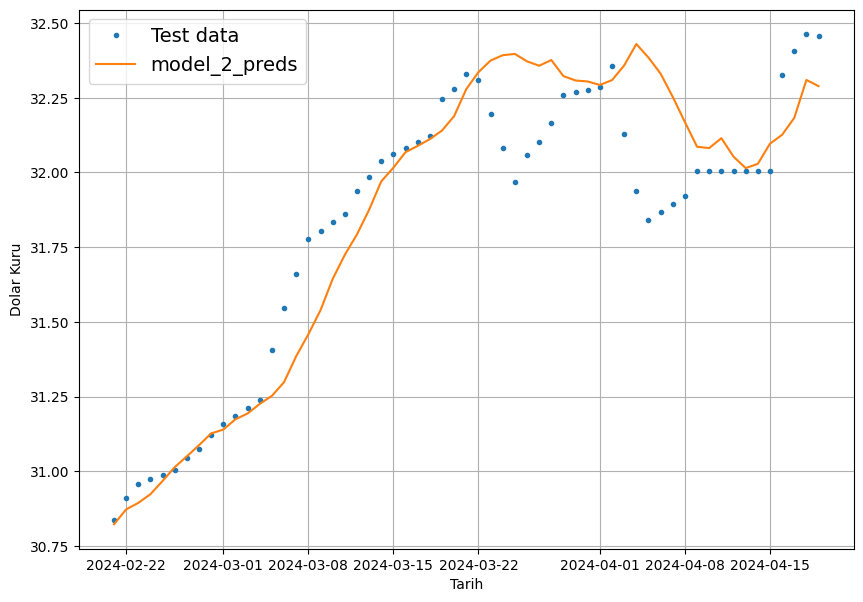

In [70]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test data") # Test veri setini çizdiriyoruz
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_2_preds,start=offset,format="-",label="model_2_preds") # Modelin tahminlerini çizdiriyoruz